In [30]:
import matplotlib.pyplot as plt
import numpy as np

from aeml.models.gbdt.plot import make_forecast_plot
from aeml.utils.io import dump_pickle, read_pickle

from darts.metrics import mae, mape, ope

from scipy.constants import golden

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']

plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'

In [2]:
times = read_pickle('step_times.pkl')

In [5]:
# using the half during length as output sequence length 
result_0_0 = read_pickle('results/20220315-232215-causalimpact_0_0')
result_0_1 = read_pickle('results/20220315-232013-causalimpact_0_1')

result_1_0 = read_pickle('results/20220313-222048-causalimpact_1_0')
result_1_1 = read_pickle('results/20220313-222743-causalimpact_1_1')

result_2_0 = read_pickle('results/20220313-223044-causalimpact_2_0')
result_2_1 = read_pickle('results/20220313-224338-causalimpact_2_1')

result_3_0 = read_pickle('results/20220313-224455-causalimpact_3_0')
result_3_1 = read_pickle('results/20220313-224749-causalimpact_3_1')

result_4_0 = read_pickle('results/20220313-224834-causalimpact_4_0')
result_4_1 = read_pickle('results/20220313-231030-causalimpact_4_1')

result_5_0 = read_pickle('results/20220313-232205-causalimpact_5_0')
result_5_1 = read_pickle('results/20220313-232935-causalimpact_5_1')

result_6_0 = read_pickle('results/20220313-233648-causalimpact_6_0')
result_6_1 = read_pickle('results/20220313-234657-causalimpact_6_1')

/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:39: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.DatetimeIndex, pd.RangeIndex, pd.Int64Index)
/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:512: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  times: Union[pd.DatetimeIndex, pd.Int64Index],
/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:738: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  def time_index(self) -> Union[pd.DatetimeIndex, pd.Int64Index]:
/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8

In [6]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [53]:
def _get_metrics(results, case: int = 1): 
    mae_score = mae(results['before'][case], results['predictions'][0])
    mape_score = mape(results['before'][case], results['predictions'][0])
    try:
        ope_score = ope(results['before'][case], results['predictions'][0])
    except Exception:
        ope_score = np.nan
    
    return {
        'mae': mae_score,
        'mape': mape_score,
        'ope': ope_score,
    }

def get_metrics(results_0, results_1): 
    metrics_0 = _get_metrics(results_0)
    metrics_1 = _get_metrics(results_1)
    return {
        '0': metrics_0,
        '1': metrics_1,
    }

In [50]:
def causalimpact_plot(result_0, result_1, day: int, outname=None):
    fig, ax = plt.subplots(1, 2, figsize=cm2inch((17.1, 17.1/1.618033988749895/2)))
    y_all = result_0['before'][1].concatenate(result_0['during'][1]).concatenate(result_0['after'][1])

    x_axis = (result_0['predictions'][0].time_index - times[day]['start'])  / np.timedelta64(1, 'h')


    ax[0].plot(x_axis, result_0['predictions'][1].pd_dataframe()[TARGETS_clean[0]], c=colors[1])
    ax[0].fill_between(x_axis, result_0['predictions'][0].pd_dataframe()[TARGETS_clean[0]],  result_0['predictions'][2].pd_dataframe()[TARGETS_clean[0]], color=colors[1], alpha=.5)

    true_subset_0 = y_all[TARGETS_clean[0]].slice_intersect(
        result_0['predictions'][0]
    )

    ax[0].plot(x_axis, true_subset_0[TARGETS_clean[0]].pd_dataframe()[TARGETS_clean[0]], '-k')

    vline_x_0 = 0
    vline_x_1 =(times[day]['end']- times[day]['start']).seconds  / (60*60)

    min_0 =min([min(true_subset_0[TARGETS_clean[0]].pd_dataframe()[TARGETS_clean[0]]),
        min(result_0['predictions'][1].pd_dataframe()[TARGETS_clean[0]])])

    max_0 =max([max(true_subset_0[TARGETS_clean[0]].pd_dataframe()[TARGETS_clean[0]]),
        max(result_0['predictions'][2].pd_dataframe()[TARGETS_clean[0]])])     

    min_0 -= 0.1 * min_0
    max_0 += 0.1 * max_0

    ax[0].vlines(vline_x_0, min_0, max_0, color='k', ls='dotted')

    ax[0].vlines(vline_x_1, min_0, max_0, color='k', ls='dotted')

    y_all = result_1['before'][1].concatenate(result_1['during'][1]).concatenate(result_1['after'][1]) 
    ax[1].plot(x_axis, result_1['predictions'][1].pd_dataframe()[TARGETS_clean[1]], c=colors[1])
    ax[1].fill_between(x_axis, result_1['predictions'][0].pd_dataframe()[TARGETS_clean[1]],  result_1['predictions'][2].pd_dataframe()[TARGETS_clean[1]], color=colors[1], alpha=.5)

    true_subset_1 = y_all[TARGETS_clean[1]].slice_intersect(
        result_1['predictions'][0]
    )

    ax[1].plot(x_axis, true_subset_1[TARGETS_clean[1]].pd_dataframe()[TARGETS_clean[1]], '-k')



    min_1 =min([min(true_subset_1[TARGETS_clean[1]].pd_dataframe()[TARGETS_clean[1]]),
        min(result_1['predictions'][1].pd_dataframe()[TARGETS_clean[1]])])
    max_1 =max([max(true_subset_1[TARGETS_clean[1]].pd_dataframe()[TARGETS_clean[1]]),
        max(result_1['predictions'][2].pd_dataframe()[TARGETS_clean[1]])])     

    min_1 -= 0.1 * min_1
    max_1 += 0.1 * max_1
    ax[1].vlines(vline_x_0, min_1, max_1, color='k', ls='dotted')

    ax[1].vlines(vline_x_1, min_1, max_1, color='k', ls='dotted')

    ax[0].set_xlabel('time w.r.t step change / h')
    ax[1].set_xlabel('time w.r.t step change / h')

    ax[0].set_title('AMP')
    ax[1].set_title('Pz')

    ax[0].set_ylabel('emissions')
    fig.tight_layout()

    if outname is not None: 
        fig.savefig(outname, bbox_inches='tight')

/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:3006: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(key, (pd.Int64Index, pd.RangeIndex)):
/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:3006: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(key, (pd.Int64Index, pd.RangeIndex)):
/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:3006: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(key, (pd.Int64Index, pd.RangeIndex)):
/Users/kevinmaikjablonka/miniconda3/envs/aeml/lib/python3.8/site-packages

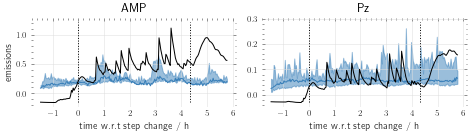

In [47]:
causalimpact_plot(result_0_0, result_0_1, 0, '20220314_ci_0.pdf')

In [54]:
get_metrics(result_0_0, result_0_1)

[2022-09-27 11:59:50,222] ERROR | darts.metrics.metrics | ValueError: The series of actual value cannot sum to zero when computing OPE.
[2022-09-27 11:59:50,233] ERROR | darts.metrics.metrics | ValueError: The series of actual value cannot sum to zero when computing OPE.


{'0': {'mae': 0.2204904970993461, 'mape': 203.51038720482185, 'ope': nan},
 '1': {'mae': 0.05486167548508333, 'mape': 668.3050810428863, 'ope': nan}}

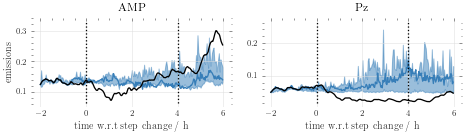

In [27]:
causalimpact_plot(result_1_0, result_1_1, 1, '20220314_ci_1.pdf')

In [55]:
get_metrics(result_1_0, result_1_1)

{'0': {'mae': 0.004724559831830777,
  'mape': 3.52921011128648,
  'ope': 1.9152944087451809},
 '1': {'mae': 0.005935794237341377,
  'mape': 9.183912443072513,
  'ope': 9.42319266787561}}

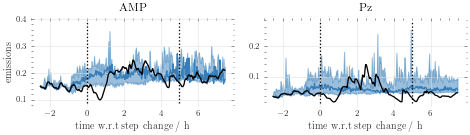

In [28]:
causalimpact_plot(result_2_0, result_2_1, 2, '20220314_ci_2.pdf')

In [56]:
get_metrics(result_2_0, result_2_1)

{'0': {'mae': 0.0064863643549892035,
  'mape': 4.404323783229881,
  'ope': 1.2509965472902185},
 '1': {'mae': 0.004238735619285648,
  'mape': 8.572983873224636,
  'ope': 6.899042428072738}}

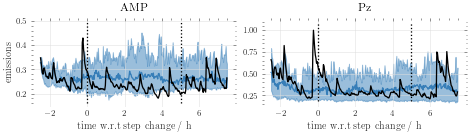

In [29]:
causalimpact_plot(result_3_0, result_3_1, 3, '20220314_ci_3.pdf')

In [58]:
get_metrics(result_3_0, result_3_1)

{'0': {'mae': 0.04048384384684695,
  'mape': 13.57750546203148,
  'ope': 15.08207698985565},
 '1': {'mae': 0.23471300953260435,
  'mape': 45.7221103666684,
  'ope': 52.395973063090025}}

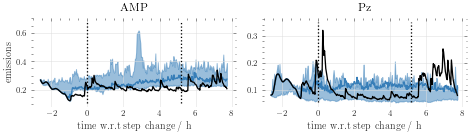

In [30]:
causalimpact_plot(result_4_0, result_4_1, 4, '20220314_ci_4.pdf')

In [59]:
get_metrics(result_4_0, result_4_1)

{'0': {'mae': 0.015713700766674322,
  'mape': 8.890622907819836,
  'ope': 3.377363347288859},
 '1': {'mae': 0.04325715657655422,
  'mape': 32.428378116697516,
  'ope': 35.51835853223632}}

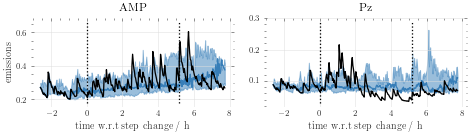

In [31]:
causalimpact_plot(result_5_0, result_5_1, 5, '20220314_ci_5.pdf')

In [60]:
get_metrics(result_5_0, result_5_1)

{'0': {'mae': 0.02575481116456133,
  'mape': 9.221255550550932,
  'ope': 10.380424458091934},
 '1': {'mae': 0.012893713674348252,
  'mape': 13.859249044292815,
  'ope': 15.658679130013631}}

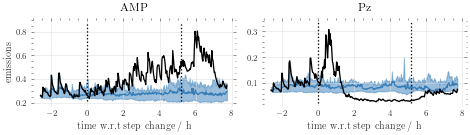

In [32]:
causalimpact_plot(result_6_0, result_6_1, 6, '20220314_ci_6.pdf')

In [61]:
get_metrics(result_6_0, result_6_1)

{'0': {'mae': 0.058129025405499246,
  'mape': 17.68708364461607,
  'ope': 19.38478365752753},
 '1': {'mae': 0.039070309400104294,
  'mape': 32.15274954177026,
  'ope': 36.445545687538385}}